### Step 6. 딥러닝 구현

# LSTM 모델 이용
4_Deep_Learning(1) 파일에서는 LSTM 모델을 이용하여 학습을 시킬 것입니다.

### csv 읽어오기

In [205]:
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
csvs = ["발라드", "랩힙합", "트로트", "CCM"]

def csv_data() :
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    f = open('4_Refined Dataset.csv','r', encoding='utf-8')
    rdr = csv.reader(f)
    for line in rdr:
        data = []
        if line[-1] == 'type' : continue
        elif line[-1] == 'train' :
            for i in range(1,len(line)-2) :
                data.append(int(line[i]))
            x_train.append(data)
            y_train.append(int(line[-2]))
        elif line[-1] == 'test' :
            for i in range(1,len(line)-2) :
                data.append(int(line[i]))
            x_test.append(data)
            y_test.append(int(line[-2]))
    f.close()
    
    # 학습 데이터 정보 출력
    print("train 데이터 수 :", len(x_train))
    for k in range(len(csvs)) :
        print(csvs[k] + " :", len([i for i in y_train if i == k]))
    print("----------------")
    print("test 데이터 수 :", len(x_test))
    for k in range(len(csvs)) :
        print(csvs[k] + " :", len([i for i in y_test if i == k]))
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = csv_data()

train 데이터 수 : 3216
발라드 : 804
랩힙합 : 804
트로트 : 804
CCM : 804
----------------
test 데이터 수 : 804
발라드 : 201
랩힙합 : 201
트로트 : 201
CCM : 201


아래 코드는 토큰화된 값의 수를 받아오는 코드입니다. 해당 값은 아래 학습 모델에서 이용됩니다. 

In [206]:
max_val_lists = []
for i in x_train :
    max_val_lists.append(max(i))
num_input = max(max_val_lists) + 1

#### train 데이터 섞기

In [207]:
train_tuple_lists = []
for i in range(len(x_train)) :
    train_tuple_lists.append((x_train[i], y_train[i]))
random.shuffle(train_tuple_lists)
x_train = [i[0] for i in train_tuple_lists]
y_train = [i[1] for i in train_tuple_lists]

#### 원-핫 인코딩
아래 과정은 위에서 만근 y_train을 원 핫 인코딩 데이터로 만드는 과정입니다. 웟 핫 인코딩된 데이터는 다음과 같은 의미를 같습니다.
1) [1, 0, 0, 0] : 발라드
2) [0, 1, 0, 0] : 랩힙합
3) [0, 0, 1, 0] : 트로트
4) [0, 0, 0, 1] : CCM

In [208]:
e = LabelEncoder()
e.fit(y_train)
Y = e.transform(y_train)
y_train = tf.keras.utils.to_categorical(Y) 
print("training 데이터 수 :", len(y_train))

e = LabelEncoder()
e.fit(y_test)
Y = e.transform(y_test)
y_test = tf.keras.utils.to_categorical(Y) 
print("test 데이터 수 :", len(y_test))

print("원 핫 인코딩된 y_train 예시\n", y_train[:3])

training 데이터 수 : 3216
test 데이터 수 : 804
원 핫 인코딩된 y_train 예시
 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


## 모델 학습

#### 학습(training)

In [209]:
class LSTM_model : # k fold에서 모델을 여러번 이용할 것이기 때문에 사용하기 쉽도록 class로 만들었습니다.
    def __init__(self) : # 모델 설계 및 컴파일
        self.model = Sequential()
        self.model.add(Embedding(num_input, 20))
        self.model.add(LSTM(32))
        self.model.add(Dense(len(csvs), activation='softmax'))
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    def learn(self, x, y, save) : # 모델 학습
        # save : 1이면 모델 저장을 합니다
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
        if save == 1 :
            mc = ModelCheckpoint('LSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
            self.history = self.model.fit(x, y, epochs=30, callbacks=[es, mc], batch_size=64, validation_split=0.2)
        else :
            self.history = self.model.fit(x, y, epochs=30, callbacks=[es], batch_size=64, validation_split=0.2)
    def graph(self) : # 그래프 그리기
        plt.plot(range(1, len(self.history.history['acc']) + 1), self.history.history['loss'])
        plt.plot(range(1, len(self.history.history['acc']) + 1), self.history.history['val_loss'])
        plt.title('loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])
        plt.show()
        plt.plot(range(1, len(self.history.history['acc']) + 1), self.history.history['acc'])
        plt.plot(range(1, len(self.history.history['acc']) + 1), self.history.history['val_acc'])
        plt.title('accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])
        plt.show()
    def test(self, x, y) : # 모델 테스트
        loaded_model = load_model('LSTM_model.h5')
        p = (loaded_model.evaluate(x, y))
        print("\n 테스트 loss값: %.4f" % p[0])
        print("\n 테스트 정확도: %.4f" % p[1])
    def return_test_acc(self, x, y) :
        return self.model.evaluate(x, y)

In [210]:
A = LSTM_model()
print(A.model.summary())

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, None, 20)          148300    
                                                                 
 lstm_51 (LSTM)              (None, 32)                6784      
                                                                 
 dense_51 (Dense)            (None, 4)                 132       
                                                                 
Total params: 155,216
Trainable params: 155,216
Non-trainable params: 0
_________________________________________________________________
None


In [211]:
A.learn(np.array(x_train), y_train, 1) 

Epoch 1/30
41/41 [==============================] - ETA: 0s - loss: 1.3569 - acc: 0.3281
Epoch 1: val_acc improved from -inf to 0.38199, saving model to LSTM_model.h5
41/41 [==============================] - 7s 147ms/step - loss: 1.3569 - acc: 0.3281 - val_loss: 1.2680 - val_acc: 0.3820
Epoch 2/30
41/41 [==============================] - ETA: 0s - loss: 1.1039 - acc: 0.4844
Epoch 2: val_acc improved from 0.38199 to 0.49845, saving model to LSTM_model.h5
41/41 [==============================] - 6s 137ms/step - loss: 1.1039 - acc: 0.4844 - val_loss: 1.0218 - val_acc: 0.4984
Epoch 3/30
41/41 [==============================] - ETA: 0s - loss: 0.9726 - acc: 0.5214
Epoch 3: val_acc did not improve from 0.49845
41/41 [==============================] - 6s 135ms/step - loss: 0.9726 - acc: 0.5214 - val_loss: 0.9576 - val_acc: 0.4953
Epoch 4/30
41/41 [==============================] - ETA: 0s - loss: 0.8649 - acc: 0.6019
Epoch 4: val_acc improved from 0.49845 to 0.51553, saving model to LSTM_mode

#### 시각화

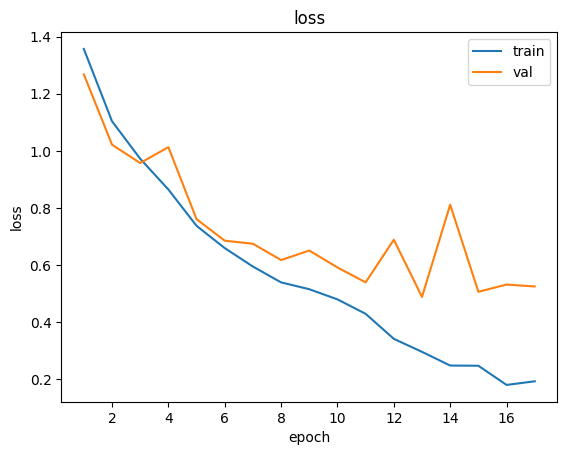

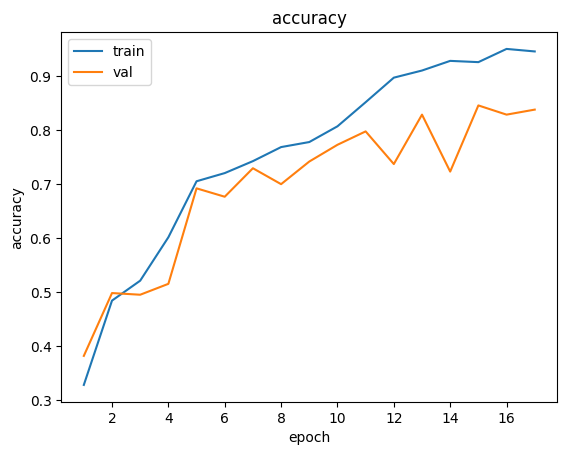

In [212]:
A.graph()

#### 평가(test)

In [213]:
A.test(np.array(x_test), y_test)

26/26 [==============================] - 1s 30ms/step - loss: 0.5319 - acc: 0.8197

 테스트 loss값: 0.5319

 테스트 정확도: 0.8197


#### 데이터셋에 없는 가사 예측
데이터셋에 없는 가사를 받아 예측하기 위해서는 데이터 정제, 가공 과정이 다시 필요합니다. 따라서 4_Dataset Processing 과정을 반복하여 tokenizer을 얻도록 했습니다. 한번 더 작성하는 대신 processing.py형태로 만들어서 가져와 사용했습니다.

In [214]:
import processing # processing.py
import re
from konlpy.tag import Okt
tokenizer = processing.processing(num_input)

def pred(data) :
    data = data.replace("\n", " ")
    data = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]',"", data)
    okt = Okt()
    data = okt.morphs(data, stem=True)
    data = tokenizer.texts_to_sequences([data])
    print("예측 : " + csvs[int(np.argmax(A.model.predict(data, verbose=0), axis=-1))])

위의 pred()함수를 이용해 예측할 수 있습니다. 가사를 그대로 가져와 아래의 변수 a에 넣은 후 pred(a)로 예측했습니다.

In [215]:
# 데이터셋에 없는 노래를 가져왔습니다. (정답 : 발라드)
a = '''이제 괜찮냐 묻지 않네요
이젠 내가 짐이 된 걸까요
멍든 내 마음이 가여워서
우습게 우리의 과거를 바래봐요
우리 만일에 마주하더라도
아무 말 없이 지나가요
그렇게 날 쳐다보지 말아요
그대 제발
더 이상 나 괴로워하지 않아요
그댄 날 잊었는데
그대도 해냈는데
나라고 못할 거 있나요
멍든 내 마음이 가여워서
이제는 우리의 과거를 지워가요
우리 만일에 마주하더라도
아무 말 없이 지나가요
그렇게 날 쳐다보지 말아요
그대 제발
더 이상 나 괴로워하지 않아요
그댄 날 잊었는데
그대도 해냈는데
나라고 못할 거 있나요
괴로워하지 않아요
그댄 날 잊었는데
그대도 해냈는데
나라고 못할 거 있나요'''

pred(a)

예측 : 발라드


In [216]:
# 데이터셋에 없는 노래를 가져왔습니다. (정답 : 랩힙합)
a = '''I know it`s your time
그런데도 너에게 간데
아마 위험한
대가는 나에게만 왜 (why)
이유가 대체 넌
뭐라 생각해?
아마 이건 참
알아도 잠시 길을 잃어 way
어제는 저기가 main
오늘은 여기로 해
네가 날 어지럽게
하는지 모르겠어 잠시 wait
귀가를 하기로 해
조금은 쉬기로 해
내가 원하는 뭘 하든
내 시간을 제발 좀 갖기로 해
반복해 너를 표현해 All day
피해자래 난 그저 웃어
The word doesn't suit you babe
아무 말도 하지마
덧붙여 말을 해
You're really so bad
난 그저 웃겨
The word
doesn't suit you babe
아무 말도 하지마 하지마
그건 아닐 거야
네가 굉장히 오해가 많아
내가 친절하게
설명해도
yeah 안 들어줘 sh*t!
너에겐 자비롭고
그런 걸 바라는 내가 참
한심해 보이며 어이없어
Next time 다음 시간을
기약하며 날 뒤로 휙
던져 버린 후에 잠시 놓기
오후 지나 밤에 다시 줍기
이런 사실을 넌 알 리 없지
노래로 처음 접하게 될 일
조금은 아쉽겠지만 뭐 어떻게
이미 다른 차에 타 있으니
네가 피해자래도
입장을 바꿔 말해줘
근데 넌 절대 모르겠지
평생을 제발 그렇겠니
반복해 너를 표현해 All day
피해자래 난 그저 웃어
The word doesn't suit you babe
아무 말도 하지마
덧붙여 말을 해
You're really so bad 난 그저 웃겨
The word doesn't suit you babe
아무 말도 하지마 하지마'''

pred(a)

예측 : 랩힙합


### 다른 모델들과 비교

#### k-fold cross validation
다른 모델들과 비교하기 위해서는 k-fold를 이용해 산출한 평균 정확도를 비교하는 것이 필요하다고 생각했습니다. k fold에 이용되는 데이터 셋으로는 위에서의 x_train과 x_test를 합친 값을 나누어 train, test 데이터로 만들어 이용했습니다.

In [218]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


def start_kfold(X, y) :
    kf = KFold(n_splits = 5, shuffle = True, random_state = 50)
    accuracy_history = []
    loss_history = []
    num = 0
    models = []
    for train_index, test_index in kf.split(X):
        num += 1
        print("--------------" + str(num) + "번째 그룹" + "----------------")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        B = LSTM_model()
        B.learn(X_train, y_train, 0)
        accuracy_history.append(B.return_test_acc(X_test, y_test)[1]) # 정확도 측정 및 기록
        loss_history.append(B.return_test_acc(X_test, y_test)[0])
    print("-----------------------------------------")
    print("------------------결과-------------------")
    print("-----------------------------------------")
    print("각 분할의 loss :", loss_history)
    print("평균 loss :", np.mean(loss_history))
    print("각 분할의 정확도 :", accuracy_history)
    print("평균 정확도 :", np.mean(accuracy_history)*100, "%")
    

start_kfold(np.array(x_train), y_train)

--------------1번째 그룹----------------
Epoch 1/30
33/33 [==============================] - 7s 167ms/step - loss: 1.3753 - acc: 0.3544 - val_loss: 1.2689 - val_acc: 0.4893
Epoch 2/30
33/33 [==============================] - 5s 159ms/step - loss: 1.0804 - acc: 0.5080 - val_loss: 1.0387 - val_acc: 0.5204
Epoch 3/30
33/33 [==============================] - 5s 147ms/step - loss: 0.9662 - acc: 0.5824 - val_loss: 1.0036 - val_acc: 0.5573
Epoch 4/30
33/33 [==============================] - 5s 165ms/step - loss: 0.9267 - acc: 0.5887 - val_loss: 0.9685 - val_acc: 0.4835
Epoch 5/30
33/33 [==============================] - 5s 152ms/step - loss: 0.8834 - acc: 0.5630 - val_loss: 0.9454 - val_acc: 0.5476
Epoch 6/30
33/33 [==============================] - 4s 137ms/step - loss: 0.8463 - acc: 0.6252 - val_loss: 0.9715 - val_acc: 0.6291
Epoch 7/30
33/33 [==============================] - 5s 149ms/step - loss: 0.7939 - acc: 0.6918 - val_loss: 0.9826 - val_acc: 0.4660
Epoch 8/30
33/33 [=====================

k-fold를 이용해 구한 loss값은 [0.6096264123916626, 0.46037110686302185, 0.5812765955924988, 0.6010134220123291, 0.7084351181983948]로 평균 0.59입니다. 정확도는 [0.8307453393936157, 0.8631415367126465, 0.7744945287704468, 0.8211508393287659, 0.699844479560852]으로 평균  79.79%입니다. 

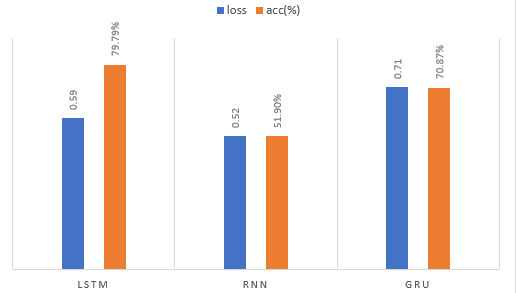

본 모델은 다른 모델(RNN, GRU)보다 높은 정확도를 보였습니다. 하지만 학습 시간이 가장 많이 걸리는 모델이기도 하였습니다.

위에서 1, 2, 3번 모델을 비교하여 LSTM 모델이 다른 모델에 비하여 더 잘 분류한다는 것을 알았습니다. 이후에는 기존의 1(LSTM-1)모델을 바꾸어 성능이 좋아지는 모델을 찾아볼 것입니다.

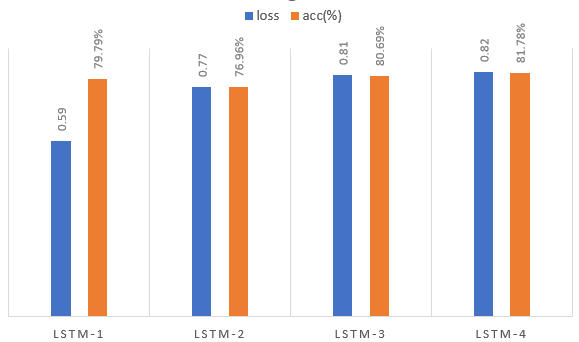

위 그래프는 LSTM 모델을 변형시킨 3종의 모델과 같이 비교한 것입니다. 정확도 측면에서 크게 차이가 나는 것은 아니지만 현재의 모델의 성능을 높일 수 있는 방법이 있었고 대표적으로 embedding층과 LSTM층의 출력 차원을 높이는 것과 배치사이즈의 크기를 줄이는 방법이 있었습니다.